# Cryptocurrency Volatility Forecasting Example

This notebook demonstrates the complete cryptocurrency volatility forecasting pipeline with detailed visualizations and explanations at each step.

## Setup Instructions

**Before running this notebook:**

1. **Install the package:** `pip install -e .` (from project root)
2. **Activate virtual environment:** `venv\Scripts\activate`
3. **Configure API keys:** Copy `.env.example` to `.env` and add your keys
4. **Start Jupyter:** `cd notebooks && jupyter lab`

## Pipeline Overview

1. **Configuration & Setup** - Define target coin and data collection parameters
2. **Data Collection** - Multi-source cryptocurrency and macroeconomic data
3. **Data Processing** - Cleaning, combining, and feature preparation
4. **Feature Engineering** - Technical indicators and TSFresh automated features
5. **Model Training** - XGBoost with Optuna hyperparameter optimization
6. **Results Analysis** - Performance evaluation and visualization

## 1. Configuration and Setup

In [1]:
# Standard library imports
import sys
import random, os, pandas as pd, numpy as np
import matplotlib.pyplot as plt, datetime as dt
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Change to repository root and add src to path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
repo_root = os.path.dirname(notebook_dir)
os.chdir(repo_root)
sys.path.append('src')

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Configure environment
os.makedirs("OutputData", exist_ok=True)
plt.rcParams['figure.figsize'] = (20, 8)

print("Environment setup completed")
print(f"Working directory: {os.getcwd()}")

Environment setup completed
Working directory: c:\VolatilityForecast\CryptoVolatilityForecast


In [2]:
# Configuration - Modify these parameters for your analysis
TARGET_COIN = "ethereum"  # Main coin to forecast
TOP_N = 10                # Number of top cryptocurrencies to include
LOOKBACK_DAYS = 365      # Historical data period
FREQUENCY = "1D"         # Data frequency: "1D" for daily, "1H" for hourly
TIMEZONE = "Europe/Madrid"

# Derived parameters
START_DATE = (dt.datetime.now() - dt.timedelta(days=LOOKBACK_DAYS)).strftime("%Y-%m-%d")
TODAY = dt.date.today().strftime('%Y-%m-%d')

# Machine learning parameters
N_TRIALS = 50            # Optuna optimization trials
N_ROUNDS = 200           # XGBoost training rounds
RANDOM_SEED = 42

print(f"Configuration:")
print(f"  Target Coin: {TARGET_COIN}")
print(f"  Data Period: {START_DATE} to {TODAY} ({LOOKBACK_DAYS} days)")
print(f"  Frequency: {FREQUENCY}")
print(f"  Universe Size: Top {TOP_N} cryptocurrencies")
print(f"  ML Trials: {N_TRIALS}")

Configuration:
  Target Coin: ethereum
  Data Period: 2024-10-02 to 2025-10-02 (365 days)
  Frequency: 1D
  Universe Size: Top 10 cryptocurrencies
  ML Trials: 50


## 2. Import Toolkit Modules

In [3]:
# Import toolkit modules
from data.collectors import CryptoDataCollector
from features.engineering import CryptoFeatureEngineer
from models.pipeline import CryptoVolatilityMLPipeline
from utils.dask_helpers import create_optimized_dask_client, cleanup_dask_client

print("All modules imported successfully")

2025-10-02 12:49:11,971 INFO numba.cuda.cudadrv.driver init


Optuna not available.
All modules imported successfully


## 3. Initialize Data Collector and Check Configuration

In [4]:
# Initialize data collector with our configuration
collector = CryptoDataCollector(
    timezone=TIMEZONE,
    top_n=TOP_N,
    lookback_days=LOOKBACK_DAYS,
    frequency=FREQUENCY,
    dune_strategy="csv_cached_execute",  # Try CSV -> cached -> execute
    allow_dune_execution=False  # Safety: no credit usage unless explicitly enabled
)

print(f"Data Collector Configuration:")
print(f"  Frequency: {collector.FREQUENCY}")
print(f"  Lookback Days: {collector.LOOKBACK_DAYS}")
print(f"  Dune Strategy: {collector.DUNE_STRATEGY}")
print(f"  Allow Dune Execution: {collector.ALLOW_DUNE_EXECUTION}")

print(f"\nAPI Frequency Resolutions:")
print(f"  Pandas: {collector.get_pandas_freq()}")
print(f"  Binance: {collector.get_binance_interval()}")
print(f"  Deribit: {collector.get_deribit_resolution()}")
print(f"  FRED: {collector.get_fred_frequency()}")
print(f"  Dune: {collector.get_dune_resolution()}")

# Check batch sizes - should reflect the actual timeframe
batch_size = collector.get_batch_size_for_frequency()
print(f"\nBatch Sizes (based on {LOOKBACK_DAYS} days at {FREQUENCY} frequency):")
print(f"  Dune Batch Size: {batch_size}")
print(f"  Expected: {LOOKBACK_DAYS} days × {24 if FREQUENCY in ['1H', '1h', 'hourly'] else 1} = {batch_size}")

print(f"\nTimeframe Verification:")
if FREQUENCY in ["1H", "1h", "hourly"]:
    print(f"  Hourly data: {LOOKBACK_DAYS} days × 24 hours = {LOOKBACK_DAYS * 24} data points")
else:
    print(f"  Daily data: {LOOKBACK_DAYS} days = {LOOKBACK_DAYS} data points")
print(f"  Batch size correctly reflects timeframe: {batch_size}")

print(f"\nDune Strategy Options:")
print(f"  'csv_only': Only load from saved CSV files")  
print(f"  'cached_only': Only use cached API results")
print(f"  'execute_only': Force fresh execution (costs credits!)")
print(f"  'csv_cached_execute': Try CSV -> cached -> execute (current setting)")

Data Collector Configuration:
  Frequency: 1D
  Lookback Days: 365
  Dune Strategy: csv_cached_execute
  Allow Dune Execution: False

API Frequency Resolutions:
  Pandas: D
  Binance: 1d
  Deribit: 1D
  FRED: Daily
  Dune: Daily

Batch Sizes (based on 365 days at 1D frequency):
  Dune Batch Size: 365
  Expected: 365 days × 1 = 365

Timeframe Verification:
  Daily data: 365 days = 365 data points
  Batch size correctly reflects timeframe: 365

Dune Strategy Options:
  'csv_only': Only load from saved CSV files
  'cached_only': Only use cached API results
  'execute_only': Force fresh execution (costs credits!)
  'csv_cached_execute': Try CSV -> cached -> execute (current setting)


In [5]:
# Test individual data sources to verify reduced verbosity
print("🧪 Testing individual data sources...")

# Test DVOL (should be clean)
print("\n📊 Testing DVOL collection...")
dvol_data = collector.deribit_get_dvol(['BTC', 'ETH'], days=7)  # Just 7 days for quick test
print(f"DVOL result: {dvol_data.shape if not dvol_data.empty else 'Empty'}")

# Test Dune with corrected query IDs (just cached, no execution)
print("\n🏛️ Testing Dune cached results with corrected query IDs...")
dune_data = collector.get_dune_data(strategy="cached_only")
print(f"Dune result: {dune_data.shape if not dune_data.empty else 'Empty'}")

print("\n✅ Individual source tests completed!")

🧪 Testing individual data sources...

📊 Testing DVOL collection...
DVOL result: (8, 2)

🏛️ Testing Dune cached results with corrected query IDs...
🔄 Using Dune strategy: cached_only
DVOL result: (8, 2)

🏛️ Testing Dune cached results with corrected query IDs...
🔄 Using Dune strategy: cached_only
⚠️  Failed to retrieve: Query 5893929 (['date']...), Query 5893461 (['date']...), Query 5893952 (['date']...) +23 more
Dune result: Empty

✅ Individual source tests completed!
⚠️  Failed to retrieve: Query 5893929 (['date']...), Query 5893461 (['date']...), Query 5893952 (['date']...) +23 more
Dune result: Empty

✅ Individual source tests completed!


## 4. Data Collection from Multiple Sources

We collect data from various sources to build a comprehensive dataset:
- **Binance/CoinGecko**: Price, volume, market cap data
- **Deribit**: Implied volatility (DVOL) for BTC and ETH
- **Dune Analytics**: On-chain metrics (uses CSV -> cached -> queries priority)
- **FRED**: Macroeconomic indicators (VIX, bond yields, etc.)

In [9]:
# Collect all data sources
print("Starting comprehensive data collection...")
data_sources = collector.collect_all_data()

# Display collected data info
print("\nData Collection Summary:")
for source, df in data_sources.items():
    if not df.empty:
        print(f"  {source}: {df.shape} | {df.index.min().date()} to {df.index.max().date()}")
        print(f"    Columns: {list(df.columns[:5])}{'...' if len(df.columns) > 5 else ''}")
    else:
        print(f"  {source}: Empty DataFrame")
    print()

Starting comprehensive data collection...
Starting comprehensive data collection...
📊 Collecting cryptocurrency universe...
Retrieved 10 coins by market cap from CoinGecko
💰 Collecting Binance price data at 1D frequency...
Fetching 1d candles for bitcoin going back 365 days...
Retrieved 10 coins by market cap from CoinGecko
💰 Collecting Binance price data at 1D frequency...
Fetching 1d candles for bitcoin going back 365 days...
Request #1: Got 1000 candles for bitcoin
Reached target date (2024-10-02) for bitcoin
Fetching 1d candles for ethereum going back 365 days...
Request #1: Got 1000 candles for bitcoin
Reached target date (2024-10-02) for bitcoin
Fetching 1d candles for ethereum going back 365 days...
Request #1: Got 1000 candles for ethereum
Reached target date (2024-10-02) for ethereum
Fetching 1d candles for ripple going back 365 days...
Request #1: Got 1000 candles for ethereum
Reached target date (2024-10-02) for ethereum
Fetching 1d candles for ripple going back 365 days...


## 5. Data Visualization - Individual Sources

NameError: name 'data_sources' is not defined

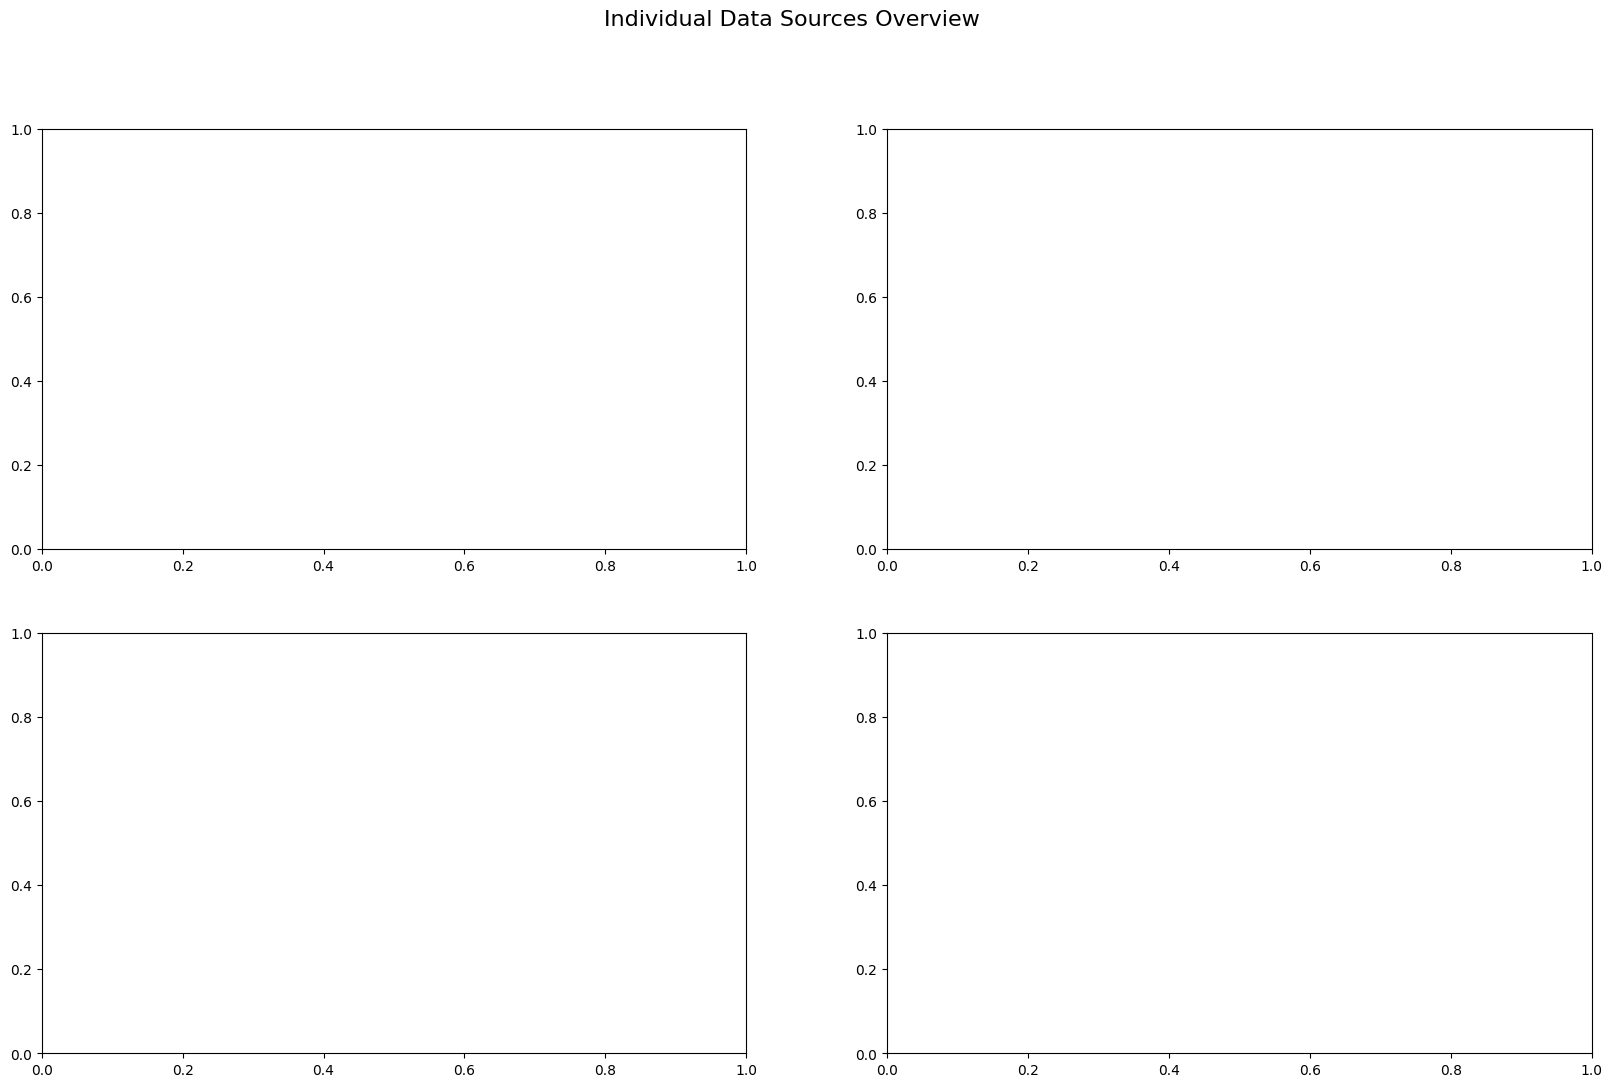

In [5]:
# Visualize individual data sources
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Individual Data Sources Overview', fontsize=16)

# Plot 1: Price data from Binance
if 'binance_price' in data_sources and not data_sources['binance_price'].empty:
    price_cols = [col for col in data_sources['binance_price'].columns if 'close_' in col]
    if price_cols:
        data_sources['binance_price'][price_cols[:5]].plot(ax=axes[0,0], title='Binance Price Data')
        axes[0,0].set_ylabel('Price (USD)')
        axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: DVOL data
if 'dvol' in data_sources and not data_sources['dvol'].empty:
    data_sources['dvol'].plot(ax=axes[0,1], title='Deribit Implied Volatility (DVOL)')
    axes[0,1].set_ylabel('Implied Volatility')
    axes[0,1].legend()

# Plot 3: Macro data from FRED
if 'macro' in data_sources and not data_sources['macro'].empty:
    # Normalize macro data for visualization
    macro_normalized = data_sources['macro'].div(data_sources['macro'].iloc[0]).fillna(1)
    macro_normalized.plot(ax=axes[1,0], title='Macroeconomic Indicators (Normalized)')
    axes[1,0].set_ylabel('Normalized Value')
    axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: On-chain data
if 'onchain' in data_sources and not data_sources['onchain'].empty:
    # Normalize on-chain data for visualization
    onchain_normalized = data_sources['onchain'].div(data_sources['onchain'].iloc[0]).fillna(1)
    onchain_normalized.plot(ax=axes[1,1], title='On-chain Analytics (Normalized)')
    axes[1,1].set_ylabel('Normalized Value')
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 6. Data Combination and Processing

In [ ]:
# Combine all data sources
unified_data = collector.combine_data_sources(data_sources)

print(f"Unified dataset shape: {unified_data.shape}")
print(f"Date range: {unified_data.index.min()} to {unified_data.index.max()}")
print(f"Total columns: {len(unified_data.columns)}")

# Show sample of the data
print("\nSample of unified data:")
display(unified_data.tail(10))

## 7. Target Variable Creation and Feature Preparation

In [ ]:
# Initialize feature engineer
engineer = CryptoFeatureEngineer(
    time_window=14,
    random_seed=RANDOM_SEED
)

# Prepare features and target variable
print(f"Preparing features and target for {TARGET_COIN}...")
X, y = engineer.prepare_target_variable(
    unified_data, 
    target_coin=TARGET_COIN
)

print(f"Base features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget ({TARGET_COIN} realized volatility) statistics:")
print(f"   Mean: {y.mean():.6f}")
print(f"   Std: {y.std():.6f}")
print(f"   Min: {y.min():.6f}")
print(f"   Max: {y.max():.6f}")

## 8. Target Variable Visualization

In [ ]:
# Visualize target variable
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle(f'{TARGET_COIN.title()} Realized Volatility Analysis', fontsize=16)

# Time series plot
y.plot(ax=axes[0,0], title='Realized Volatility Over Time')
axes[0,0].set_ylabel('Realized Volatility')
axes[0,0].grid(True)

# Histogram
y.hist(bins=50, ax=axes[0,1], title='Distribution of Realized Volatility')
axes[0,1].set_xlabel('Realized Volatility')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True)

# Rolling statistics
rolling_30 = y.rolling(30).mean()
rolling_90 = y.rolling(90).mean()
axes[1,0].plot(y.index, y, alpha=0.3, label='Daily')
axes[1,0].plot(y.index, rolling_30, label='30-day MA')
axes[1,0].plot(y.index, rolling_90, label='90-day MA')
axes[1,0].set_title('Realized Volatility with Moving Averages')
axes[1,0].set_ylabel('Realized Volatility')
axes[1,0].legend()
axes[1,0].grid(True)

# Autocorrelation (simple version)
lags = range(1, 21)
autocorr = [y.autocorr(lag=lag) for lag in lags]
axes[1,1].bar(lags, autocorr)
axes[1,1].set_title('Autocorrelation of Realized Volatility')
axes[1,1].set_xlabel('Lag (days)')
axes[1,1].set_ylabel('Autocorrelation')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

## 9. Technical Analysis Indicators

In [ ]:
# Add technical analysis indicators
print("Computing technical analysis indicators...")
ta_indicators = engineer.compute_ta_indicators(X, price_prefix="prices_")

if not ta_indicators.empty:
    # Combine with base features
    X_with_ta = X.join(ta_indicators, how='left').dropna()
    
    # Align indices
    common_idx = X_with_ta.index.intersection(y.index)
    X = X_with_ta.loc[common_idx]
    y = y.loc[common_idx]
    
    print(f"Added {ta_indicators.shape[1]} technical indicators")
    print(f"Features with TA shape: {X.shape}")
    
    # Show sample technical indicators
    ta_cols = [col for col in X.columns if any(indicator in col for indicator in ['rsi', 'macd', 'sma', 'ema'])]
    if ta_cols:
        print(f"Sample technical indicators: {ta_cols[:5]}")
else:
    print("No technical indicators computed (TA-Lib may not be available)")

## 10. Technical Indicators Visualization

In [ ]:
# Visualize some technical indicators for the target coin
if not ta_indicators.empty:
    target_price_col = f"prices_{TARGET_COIN}"
    target_rsi_col = f"rsi14_{TARGET_COIN}"
    target_macd_col = f"macd_{TARGET_COIN}"
    
    if target_price_col in X.columns:
        fig, axes = plt.subplots(3, 1, figsize=(20, 12))
        fig.suptitle(f'{TARGET_COIN.title()} Technical Analysis', fontsize=16)
        
        # Price with moving averages
        axes[0].plot(X.index, X[target_price_col], label='Price', alpha=0.7)
        sma_cols = [col for col in X.columns if f"sma" in col and TARGET_COIN in col]
        for col in sma_cols[:3]:  # Show first 3 SMAs
            axes[0].plot(X.index, X[col], label=col.replace(f"_{TARGET_COIN}", "").upper())
        axes[0].set_title('Price with Moving Averages')
        axes[0].set_ylabel('Price (USD)')
        axes[0].legend()
        axes[0].grid(True)
        
        # RSI
        if target_rsi_col in X.columns:
            axes[1].plot(X.index, X[target_rsi_col], label='RSI', color='orange')
            axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
            axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
            axes[1].set_title('Relative Strength Index (RSI)')
            axes[1].set_ylabel('RSI')
            axes[1].legend()
            axes[1].grid(True)
        
        # MACD
        if target_macd_col in X.columns:
            macd_signal_col = f"macd_signal_{TARGET_COIN}"
            macd_hist_col = f"macd_hist_{TARGET_COIN}"
            
            axes[2].plot(X.index, X[target_macd_col], label='MACD', color='blue')
            if macd_signal_col in X.columns:
                axes[2].plot(X.index, X[macd_signal_col], label='Signal', color='red')
            if macd_hist_col in X.columns:
                axes[2].bar(X.index, X[macd_hist_col], label='Histogram', alpha=0.3, color='green')
            axes[2].set_title('MACD')
            axes[2].set_ylabel('MACD')
            axes[2].legend()
            axes[2].grid(True)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Price column for {TARGET_COIN} not found in features")
else:
    print("No technical indicators to visualize")

## 11. Initialize Distributed Computing

In [ ]:
# Initialize Dask distributed computing cluster
client = create_optimized_dask_client(
    n_workers=4,
    threads_per_worker=2,
    memory_limit='4GB',
    dashboard_port=8787,
    processes=True
)

print(f"Dask cluster ready at: http://localhost:8787/status")
display(client)

## 12. TSFresh Feature Engineering

In [ ]:
# Run TSFresh pipeline with Dask
print("Starting TSFresh feature extraction with Dask...")
print("This may take several minutes depending on data size...")

tsfresh_features = engineer.run_tsfresh_pipeline(X, y, client)

if not tsfresh_features.empty:
    print(f"TSFresh features extracted: {tsfresh_features.shape}")
    print(f"Sample TSFresh features: {list(tsfresh_features.columns[:5])}")
else:
    print("No TSFresh features extracted")

## 13. Final Feature Set Creation

In [ ]:
# Create final feature set
print("Creating final feature set...")
final_features = engineer.create_final_feature_set(
    X_base=X,
    y=y,
    tsfresh_features=tsfresh_features,
    include_ta_indicators=True
)

print(f"Final feature set shape: {final_features.shape}")

# Show feature breakdown
feature_cols = final_features.drop('target', axis=1).columns
tsfresh_count = len([col for col in feature_cols if '__' in col])  # TSFresh features contain '__'
base_count = len(feature_cols) - tsfresh_count

print(f"\nFeature breakdown:")
print(f"   Base + TA features: {base_count}")
print(f"   TSFresh features: {tsfresh_count}")
print(f"   Total features: {len(feature_cols)}")

# Show sample of final features
print("\nSample of final feature set:")
display(final_features.tail())

## 14. Feature Correlation Analysis

In [ ]:
# Analyze feature correlations with target
correlations = final_features.drop('target', axis=1).corrwith(final_features['target']).abs().sort_values(ascending=False)

print("Top 20 features by correlation with target:")
display(correlations.head(20))

# Visualize top correlations
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bar plot of top correlations
correlations.head(15).plot(kind='bar', ax=axes[0], title='Top 15 Feature Correlations with Target')
axes[0].set_ylabel('Absolute Correlation')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Correlation distribution
correlations.hist(bins=30, ax=axes[1], title='Distribution of Feature Correlations')
axes[1].set_xlabel('Absolute Correlation with Target')
axes[1].set_ylabel('Number of Features')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 15. Machine Learning Pipeline

In [ ]:
# Initialize ML pipeline
ml_pipeline = CryptoVolatilityMLPipeline(
    n_trials=N_TRIALS,
    n_rounds=N_ROUNDS,
    eval_metric='mae',
    tree_method='hist',
    early_stopping_rounds=25,
    splits=5,
    random_seed=RANDOM_SEED
)

print(f"ML Pipeline Configuration:")
print(f"   Optimization Trials: {N_TRIALS}")
print(f"   Training Rounds: {N_ROUNDS}")
print(f"   Evaluation Metric: mae")
print(f"   Cross-validation Splits: 5")

In [ ]:
# Run complete ML pipeline
print("Starting complete ML pipeline...")
print("This will take several minutes for hyperparameter optimization...")

ml_results = ml_pipeline.run_complete_pipeline(
    final_features=final_features,
    client=client,
    target_coin=TARGET_COIN,
    optimize=True
)

print("ML Pipeline completed!")

## 16. Results Analysis

In [ ]:
# Extract results
study = ml_results['study']
final_model = ml_results['final_model']
metrics = ml_results['metrics']
y_test_pd = ml_results['y_test_pd']
predictions_pd = ml_results['predictions_pd']

# Display optimization results
print("Hyperparameter Optimization Results:")
print("=" * 50)
print(f"Best parameters: {study.best_params}")
print(f"Best MAE: {study.best_value:.6f}")
print(f"Number of trials: {len(study.trials)}")

# Display model performance
print("\nModel Performance Metrics:")
print("=" * 50)
for metric, value in metrics.items():
    print(f"{metric.upper()}: {value:.6f}")

## 17. Feature Importance Analysis

In [ ]:
# Feature importance analysis
try:
    importance = final_model['booster'].get_score(importance_type='weight')
    top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]
    
    print("Top 20 Most Important Features:")
    for i, (feature, score) in enumerate(top_features, 1):
        print(f"  {i:2d}. {feature}: {score}")
    
    # Visualize feature importance
    features_df = pd.DataFrame(top_features, columns=['Feature', 'Importance'])
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(features_df)), features_df['Importance'])
    plt.yticks(range(len(features_df)), features_df['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not extract feature importance: {e}")

## 18. Prediction Visualization and Analysis

In [ ]:
# Comprehensive prediction analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle(f'{TARGET_COIN.title()} Volatility Forecasting Results', fontsize=16)

# Time series plot
viz = pd.DataFrame({'Actual': y_test_pd, 'Predicted': predictions_pd})
viz.plot(ax=axes[0,0], title='Predicted vs Actual Volatility Over Time')
axes[0,0].set_ylabel('Realized Volatility')
axes[0,0].legend()
axes[0,0].grid(True)

# Scatter plot with perfect prediction line
axes[0,1].scatter(viz['Actual'], viz['Predicted'], alpha=0.6)
max_val = max(viz['Actual'].max(), viz['Predicted'].max())
min_val = min(viz['Actual'].min(), viz['Predicted'].min())
axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
axes[0,1].set_xlabel('Actual Volatility')
axes[0,1].set_ylabel('Predicted Volatility')
axes[0,1].set_title('Prediction Accuracy Scatter Plot')
axes[0,1].legend()
axes[0,1].grid(True)

# Residuals plot
residuals = viz['Actual'] - viz['Predicted']
residuals.plot(ax=axes[1,0], title='Prediction Residuals Over Time')
axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[1,0].set_ylabel('Residuals')
axes[1,0].grid(True)

# Residuals histogram
residuals.hist(bins=30, ax=axes[1,1], title='Distribution of Residuals')
axes[1,1].axvline(x=0, color='r', linestyle='--', alpha=0.7)
axes[1,1].set_xlabel('Residuals')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

## 19. Model Performance Summary

In [ ]:
# Comprehensive performance summary
print("CRYPTOCURRENCY VOLATILITY FORECASTING RESULTS")
print("=" * 60)

# Basic info
print(f"Target Cryptocurrency: {TARGET_COIN.title()}")
print(f"Forecast Horizon: 1 day ahead")
print(f"Training Period: {final_features.index.min().date()} to {final_features.index.max().date()}")
print(f"Test Period: {y_test_pd.index.min().date()} to {y_test_pd.index.max().date()}")
print(f"Total Features Used: {final_features.shape[1] - 1}")

# Model performance
print(f"\nModel Performance:")
r2 = metrics['r2_score']
mae = metrics['mae']
mse = metrics['mse']
mape = metrics.get('mape', 'N/A')
mase = metrics.get('mase', 'N/A')

print(f"   R² Score: {r2:.6f}")
print(f"   Mean Absolute Error: {mae:.6f}")
print(f"   Mean Squared Error: {mse:.6f}")
print(f"   RMSE: {np.sqrt(mse):.6f}")
if mape != 'N/A':
    print(f"   MAPE: {mape:.6f}")
if mase != 'N/A':
    print(f"   MASE: {mase:.6f}")

# Statistical analysis
correlation = predictions_pd.corr(y_test_pd)
print(f"\nStatistical Analysis:")
print(f"   Prediction-Actual Correlation: {correlation:.6f}")
print(f"   Mean Actual Volatility: {y_test_pd.mean():.6f}")
print(f"   Mean Predicted Volatility: {predictions_pd.mean():.6f}")
print(f"   Actual Volatility Std: {y_test_pd.std():.6f}")
print(f"   Predicted Volatility Std: {predictions_pd.std():.6f}")

# Model interpretation
print(f"\nModel Insights:")
if r2 > 0.5:
    print(f"   ✅ Good explanatory power (R² = {r2:.3f})")
elif r2 > 0.2:
    print(f"   ⚠️  Moderate explanatory power (R² = {r2:.3f})")
else:
    print(f"   ❌ Low explanatory power (R² = {r2:.3f})")

if mase != 'N/A' and mase < 1.0:
    print(f"   ✅ Outperforms naive forecast (MASE = {mase:.3f})")
elif mase != 'N/A':
    print(f"   ❌ Underperforms naive forecast (MASE = {mase:.3f})")

# Hyperparameter summary
best_params = study.best_params
print(f"\nOptimal Hyperparameters:")
print(f"   Learning Rate: {best_params.get('learning_rate', 'N/A'):.4f}")
print(f"   Max Depth: {best_params.get('max_depth', 'N/A')}")
print(f"   Subsample: {best_params.get('subsample', 'N/A'):.3f}")
print(f"   Feature Fraction: {best_params.get('colsample_bytree', 'N/A'):.3f}")

print(f"\n{'='*60}")
print("Analysis completed successfully!")

## 20. Cleanup

In [ ]:
# Cleanup Dask client
cleanup_dask_client(client)
print("Dask client cleaned up")
print("\nNotebook execution completed successfully!")
print(f"Your {TARGET_COIN} volatility forecasting model is ready for use.")